# Library

In [1]:
%matplotlib inline
import datetime
import time
timeformat = "%Y-%m-%d %H:%M:%S"

from sklearn import neural_network
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.plotly as py
from sklearn.metrics import mean_squared_error
from math import sqrt

plt.rcParams['figure.figsize'] = [16.0, 6.0]
colors = {'MLP':'C3', 'RT':'C2', 'LR':'C1', 'Real':'C0'}

# Global

In [2]:
predict = dict()

# Function

# Data preprocess

In [3]:
pm25 = pd.read_csv("../data/Erlin.csv", parse_dates=True)[['PM2.5']]

In [4]:
#meteorology = pd.read_csv("../data/Erlin.csv", parse_dates=True)
#meteorology = pd.read_csv("../data/Erlin_minmax.csv", parse_dates=True)
#meteorology = pd.read_csv("../data/Erlin_zscore.csv", parse_dates=True)
meteorology = pd.read_csv("../data/Erlin_normalization.csv", parse_dates=True)
meteorology = meteorology[['AMB_TEMP', 'RAINFALL', 'RH', 'WIND_SPEED']]

## to forecast PM2.5(t), we use RAINFALL(t-1) instead of RAINFALL(t)
## cause we could not know RAINFALL(t) from weather forecast
meteorology.RAINFALL = meteorology.RAINFALL.shift()

In [5]:
date_feature = pd.read_csv("../data/date_feature.csv", parse_dates=True)

In [6]:
time_series = pd.read_csv("../data/pm2.5_timeseries.csv", parse_dates=True)
time_series = time_series[[column for column in time_series.columns if column not in ['datetime']]]
time_lags = ['t-'+str(x+1) for x in range(12)]
time_series = time_series[time_lags]

In [7]:
data = pd.concat([pm25, meteorology, time_series, date_feature], axis=1)

In [8]:
target = "PM2.5"
exclude = ['datetime', target]
features = [f for f in data.columns if f not in exclude]
print features

['AMB_TEMP', 'RAINFALL', 'RH', 'WIND_SPEED', 't-1', 't-2', 't-3', 't-4', 't-5', 't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'season_1', 'season_2', 'season_3', 'season_4']


# Data

In [9]:
DateStart = '2016-06-01 00:00:00'
DateEnd = '2016-12-31 00:00:00'

start = data[data.datetime.values == DateStart].index[0]
end = data[data.datetime.values == DateEnd].index[0]

#train = pd.concat([data[:start], data[end:]], axis=0).dropna()
train = data[:start].dropna()
test = data[start:end]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Regression Tree

In [10]:
start_time = time.time()

RT = AdaBoostRegressor(DecisionTreeRegressor())
RT.fit(X_train, y_train)
'''zipped = sorted(zip(features, RT.feature_importances_), key = lambda imp: imp[1])
print 'Feature : Importances'
for f, imp in zipped:
    print f, ':', imp'''

predict["RT"] = RT.predict(X_test)

end_time = time.time()
print "Time consume: ", end_time - start_time, ' s.'

Time consume:  88.8010361195  s.


# Linear Regression

In [11]:
start_time = time.time()

LR = linear_model.LinearRegression()
LR.fit(X_train, y_train)
'''zipped = sorted(zip(features, LR.coef_), key = lambda coef: coef[1])
print 'Feature : Coefficients'
for f, coef in zipped:
    print f, ':', coef'''

predict["LR"] = LR.predict(X_test)

end_time = time.time()
print "Time consume: ", end_time - start_time, ' s.'

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



Time consume:  0.317483186722  s.


# MLP Regression

In [12]:
start_time = time.time()

MLP = neural_network.MLPRegressor(activation='relu')
MLP.fit(X_train, y_train)
print 'Model: \n', MLP

predict["MLP"] = MLP.predict(X_test)

end_time = time.time()
print "Time consume: ", end_time - start_time, ' s.'

Model: 
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
Time consume:  9.86088323593  s.


# Measure

In [13]:
rmse = dict()
rmse['model'], rmse['value'] = [], []
for key, value in predict.iteritems():
    rmse['model'].append(key)
    rmse['value'].append(sqrt(mean_squared_error(value, y_test)))

print rmse

{'model': ['RT', 'MLP', 'LR'], 'value': [5.564097047158857, 5.207473208104134, 5.502176159455974]}


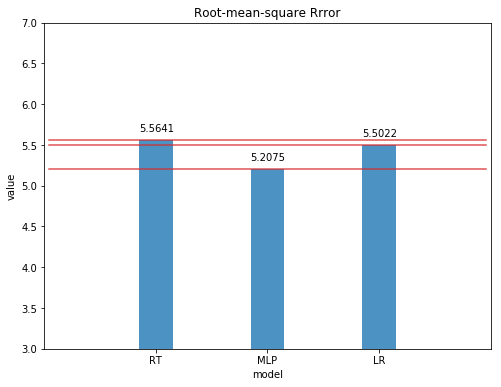

In [14]:
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.bar(range(3), rmse['value'], width=0.3, color='C0', alpha=0.8)
for x in range(len(rmse['value'])):
    plt.axhline(y=rmse['value'][x], color='C3', xmin=0.01, xmax=0.99, alpha=0.8)
    plt.text(x - 0.15 , rmse['value'][x] + 0.1, str(round(rmse['value'][x], 4)), color='k')
plt.xticks(range(3), rmse['model'])
plt.title('Root-mean-square Rrror')
plt.xlabel('model')
plt.ylabel('value')
plt.ylim([3,7])
plt.xlim([-1,3])
fig = plt.gcf()
plt.show()

# Plot

In [15]:
plt.rcParams['figure.figsize'] = [16.0, 6.0]

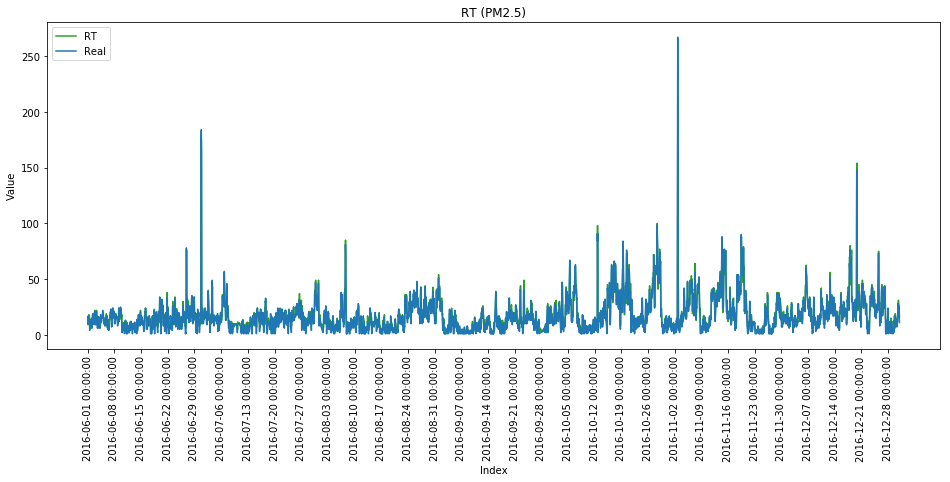

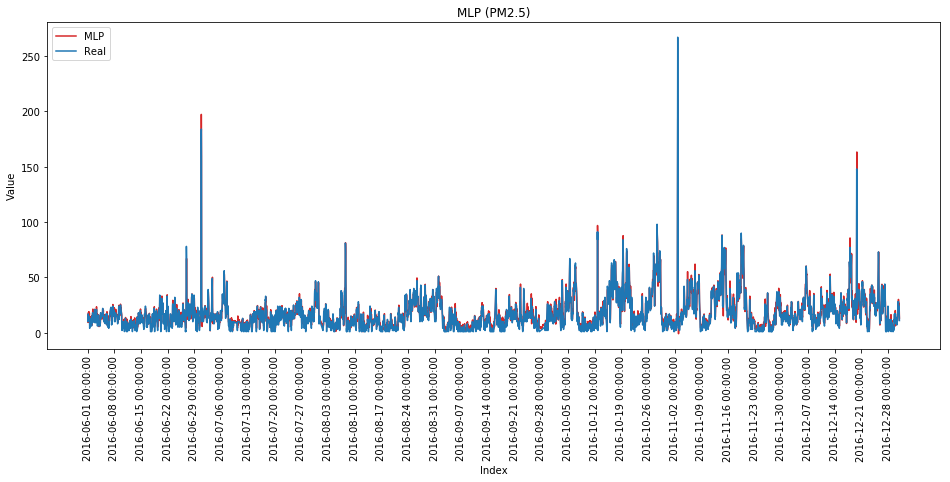

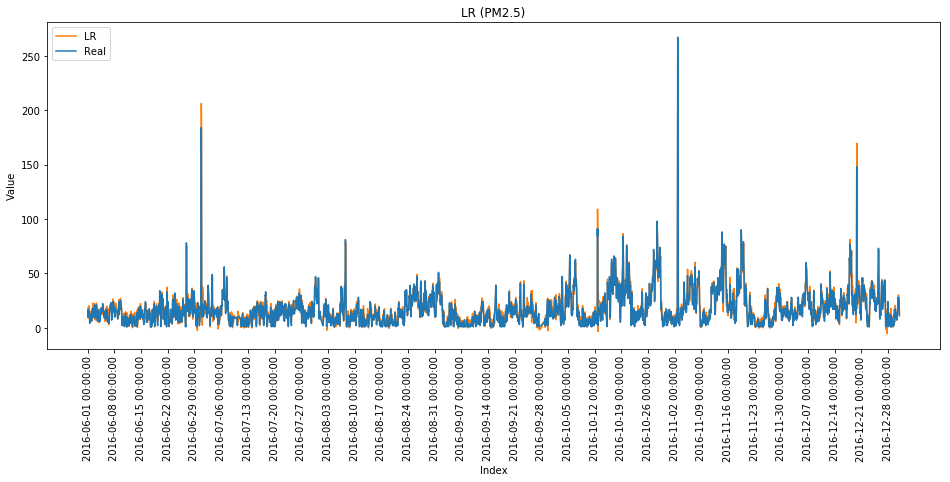

In [30]:
for key, value in predict.iteritems():
    plt.title(key + ' (' + target + ')')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.plot(predict[key], colors[key], label = key)
    plt.plot(y_test.tolist(), colors['Real'], label = 'Real')
    plt.xticks(range(0,len(predict[key]),24*7), test.datetime.tolist()[::24*7])
    plt.xticks(rotation=90)
    plt.legend(loc='upper left')
    plt.show()

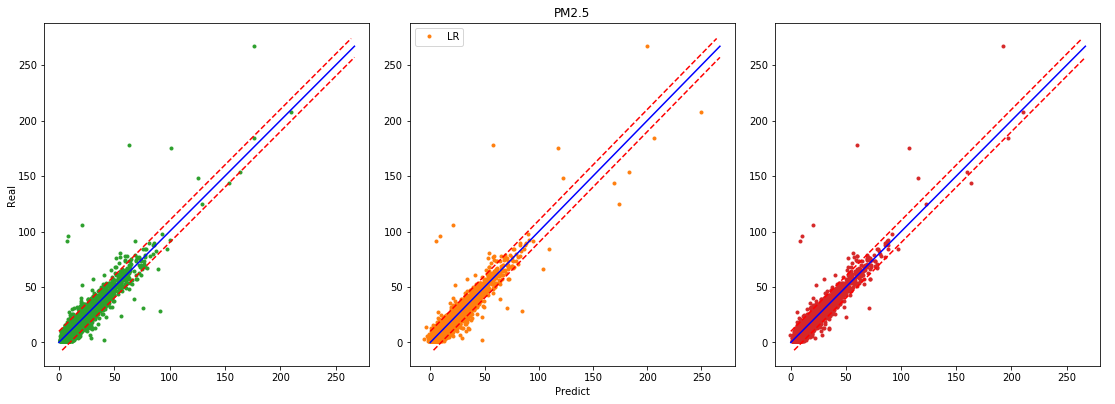

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.title.set_text(target)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel('Predict')
ax.set_ylabel('Real')

subplot = {'RT':131, 'LR':132, 'MLP':133}
for key, value in predict.iteritems():
    sub_ax = fig.add_subplot(subplot[key])
    sub_ax.plot(value, y_test.tolist(), colors[key] + '.', label=key)
    
    a, b = 0, max(max(y_test.tolist()), 24)
    mrange = 10 
    sub_ax.plot([a, b], [a, b], 'b-')
    sub_ax.plot([a, b - 3], [a+mrange, b+mrange -3], 'r--')
    sub_ax.plot([a + 3, b], [a-mrange + 3, b-mrange], 'r--')
    
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()